In [1]:
'''将训练集中的后30个做验证集，前81个做训练集，然后探究模型自身在训练集和验证集上的效果'''
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
import numpy as np
import pandas as pd
from pandas import DataFrame
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [2]:
filepath = "train.csv"
train_data = pd.read_csv(filepath) #抛弃了验证集后30条序列的训练集
dev_data = pd.read_csv("dev.csv")

'''将train.csv and test.csv 中的数据转化为np.array，按照原格式111*735一行一行的存入数组中'''
def loaddata(data, rows, lines):#将每一行的各列的数据放入train_data_row中
    data_rows=[]
    for row in range(0,rows):
        data_row=[]
        for line in range(0,lines):
            data_row.append(data[str(line)][row]) #将每一行的各列的数据放入train_data_row中
        data_rows.append(data_row)
    return np.array(data_rows)

def normalizationdata(data):  #归一化
    range = np.max(data) - np.min(data)
    return (data - np.min(data)) / range

'''将训练数据和测试数据的每一行都装入train_data_rows'''
train_data_rows = loaddata(train_data, 81, 735)
dev_data_rows = loaddata(dev_data, 30, 735)

'''将数据归一化处理'''
train_data_rows_nor = normalizationdata(train_data_rows)
dev_data_rows_nor = normalizationdata(dev_data_rows)
#test_data_rows_nor[0]

'''
不重叠的将每一行数据划分为输入输出对
根据不同的输入步长num_row，输出步长output_size,将分割出来的数据放入到data_rows中
data_rows=[训练数据(num_row)，训练数据的验证(长度为56)
输入的数据为归一化处理过后的训练集，以及输入步长
输入：正则化数据，输入长度，输出长度，数据的行数'''
def input_size(data_nor, num_row, output_size, rows):#输出为定长56，而输入长度可以改变，为num_rows,
    train_data_rows = []
    test_data_rows = []

    for row in range(0,rows):  #去掉验证集后的训练集只有81行
        train_data_row = []
        test_data_row = []
        
        count = 0
        line = 0
        while count + num_row + output_size - 1 < 735:
            data_row_train = []
            data_row_test = []
            line = count   #不重叠的获得输入输出对，即如：1，2，3，4，5，6   获得数据为输入（1）输出（2）；输入（3）输出（4）；输入（5）输出（6）

            while True:
                if count  < line+num_row:
                    data_row_train.append(data_nor[row][count]) #将每一行的各列的数据放入data_row_train中
                    count += 1

                elif count >= line+num_row and count<line+num_row+output_size:#如果count大于等于输入步长且小于输入加输出步长，则输入到data_row_test中
                    data_row_test.append(data_nor[row][count])
                    count += 1
                
                elif count == line+num_row+output_size: #如果输入输出步长加上起始位置超过最大列下标，则推出本行循环
                    break

            train_data_row.append(data_row_train)
            test_data_row.append(data_row_test)

        train_data_rows.append(train_data_row)
        test_data_rows.append(test_data_row)

    return np.array(train_data_rows), np.array(test_data_rows)
    
'''得到不同输入步长的训练集合,training_data_input_x的维度为(行数（111），每一行划分成了多少个训练样本/测试样本集合，输入步长)'''
training_data_input_56, train_data_output_56 = input_size(train_data_rows_nor, 56, 56, 81)
dev_data_input_56, dev_data_output_56 = input_size(dev_data_rows_nor, 56, 56, 30)

training_data_input_112, train_data_output_112 = input_size(train_data_rows_nor, 112, 56, 81)
dev_data_input_112, dev_data_output_112 = input_size(dev_data_rows_nor, 112, 56, 30)

training_data_input_679, train_data_output_679 = input_size(train_data_rows_nor, 679, 56, 81)
dev_data_input_679, dev_data_output_679 = input_size(dev_data_rows_nor, 679, 56, 30)

'''将数据转化为tensor'''
train_input_56, train_output_56 = torch.tensor(training_data_input_56), torch.tensor(train_data_output_56)
train_input_112, train_output_112 = torch.tensor(training_data_input_112), torch.tensor(train_data_output_112)
train_input_679, train_output_679 = torch.tensor(training_data_input_679), torch.tensor(train_data_output_679)

'''将数据转化为tensor'''
dev_input_56, dev_output_56 = torch.tensor(dev_data_input_56), torch.tensor(dev_data_output_56)
dev_input_112, dev_output_112 = torch.tensor(dev_data_input_112), torch.tensor(dev_data_output_112)
dev_input_679, dev_output_679 = torch.tensor(dev_data_input_679), torch.tensor(dev_data_output_679)




以上是处理数据，最终得到训练集和验证集的输入和标签（输出）

In [3]:
'''建立LSTM模型'''
class RNN(nn.Module):
    def __init__(self, input_size = 679):
        super(RNN,self).__init__()
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size,32,2) #输入数据input_size个特征维度，32个隐藏层维度，4个LSTM串联，第二个LSTM接收第一个的计算结果
#两个特征维度表示输入序列中的inpuge_size个数字进模型，32个隐藏层维度说明输出为32个值，4个LSTM串联表示两个LSTM堆叠起来，上一个LSTM输出的值输入到下一个LSTM中 

        self.linear = nn.Linear(32,56) #线性拟合，接收数据的维度为32，输出数据的维度为56
#线性层，即多层感知机那样的层，将LSTM6个隐藏层的输出值输入到线性层中，然后输出输出步长个值，如果要对未来56天的数据进行预测，则应该为(32,56)

    def forward(self,x):
        x1,_ = self.lstm(x)
        #https://zhuanlan.zhihu.com/p/39191116
        #lstm的输出有两个，output和(hn,cn)
        #output的时间序列行数（如果是句子就是句子个数），batch_size, 隐藏单元个数
        #output是最后一层lstm隐藏层的输出
        # hn,cn是所有层最后一个隐藏元和记忆元的输出
        a,b,c = x1.shape
        out = self.linear(x1.view(-1,c))
        #将lstm输出的输出步长(56)个值输入到线性层中

        #view(-1,c)函数将其自动调整为x1.shape[0]*c = 初始的所有元素个数
        out1 = out.view(a,b,-1)
        #线性层的输出调整为有多少个数据以及batch，最后一个维度(-1)是输出步长大小
        
        return out1

In [4]:
'''训练函数，并且算出对训练集的sMAPE'''
def train(training_datas, label_datas, model, optimizer, loss_fuc, input_size, epochs = 500):
    losses = [] 
    iter = []

    for epoch in range(epochs):
        #整体的数据输入进去，然后模型自己通过SGD进行优化
        #所以一次循环就是对所有数据进行训练一次，即一个epoch
        X_datas = training_datas.type(torch.float32).to(device)
        Y_datas = label_datas.type(torch.float32).to(device)
        #因为输入的数据已经是包含三个维度的了，并且每一行的输入输出对刚好可以成为batch_size所以不用改变形状了

        pred = model(X_datas)
        loss = loss_fuc(pred, Y_datas)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            losses.append(loss.item())
            print("the loss of epoch：   " +str(epoch) + "   is: "+ str(loss.item()))
            iter.append(epoch)
    
    #训练完毕
    prediction = model(X_datas[:, [X_datas.shape[1]-1], :]) #prediction为利用模型利用训练数据每行最后的输入长度个的值为输入，输出56个输出作为prediction
    #预测值为X_datas的第2个维度的最后一个输入

    plt.title("loss of epoch per 100————"+str(loss_fuc)+ ","+ str(epochs)+ "epochs,"+"input size is:"+str(input_size))
    plt.xlabel("loss per 100")
    plt.ylabel("LOSS")
    plt.plot(iter, losses)
    plt.show()

    return prediction.to('cpu')  #为了后续smape的计算在cpu上
    #得到的训练集为训练数据中的输入部分的最后一个输入步长进入模型训练得到的预测值，目的是与最后对应输出数据作为标签计算sMAPE

'''sMAPE精确度指标'''
def sMAPE(pred, y):
    n = pred.shape[0] * pred.shape[1] 
    sum = abs(pred-y)/(abs(pred+y)/2)
    acc = torch.sum(sum)/n #将所有元素相加
    return acc*100

'''将归一化的数据恢复成原本的数据'''
def reverse_normalizationdata(data,max,min):
    range = max - min
    return torch.mul(data, range)+min

'''计算训练集自身预测值和输出对的标签的sMAPE指标
输入未归一化的训练数据，预测的prediction，未归一化的测试数据以及输入长度'''
def cal_sMAPE_train(train_data_rows, prediction, input_size):

    train_max = np.max(train_data_rows, axis=1)  #axis=1表示求各行的最大值
    train_min = np.min(train_data_rows, axis=1)

    train_max_ts = torch.tensor(train_max).view(train_max.shape[0],1,-1)
    train_min_ts = torch.tensor(train_min).view(train_max.shape[0],1,-1)
    #上面求得了符合格式的最大值和最小值
    pred = reverse_normalizationdata(prediction, train_max_ts, train_min_ts)#将prediction按照训练集每行相应的最大最小值反归一化
    y = torch.tensor(train_data_rows[:,[range(679,735)]]).view(prediction.shape[0], 1, -1) #得到训练集最后的56个输出作为标签
    #将未归一化的测试集数据转换成和prediction一样的形状
    #将没有归一化的训练数据的每一行后56个元素当作标签


    acc = sMAPE(pred.view(1,-1), y.view(1,-1)) #将其转化为2维的数据，sMAPE只用乘两个维度的数据算总元素个数

    print("输入步长为"+str(input_size)+"的训练集/验证集上的sMAPE指标："+str(acc.item())) #item可以只保留数字

    return acc

以下是对训练集自身的sMAPE和损失的计算

the loss of epoch：   0   is: 0.07455893605947495
the loss of epoch：   100   is: 0.06563770771026611
the loss of epoch：   200   is: 0.05810542777180672
the loss of epoch：   300   is: 0.05162530019879341
the loss of epoch：   400   is: 0.04597564414143562
the loss of epoch：   500   is: 0.041007883846759796
the loss of epoch：   600   is: 0.03662019222974777
the loss of epoch：   700   is: 0.03274013474583626
the loss of epoch：   800   is: 0.029313240200281143
the loss of epoch：   900   is: 0.026295632123947144
the loss of epoch：   1000   is: 0.02364950440824032
the loss of epoch：   1100   is: 0.021340468898415565
the loss of epoch：   1200   is: 0.019336141645908356
the loss of epoch：   1300   is: 0.017605600878596306
the loss of epoch：   1400   is: 0.016119228675961494
the loss of epoch：   1500   is: 0.014848882332444191
the loss of epoch：   1600   is: 0.013768118806183338
the loss of epoch：   1700   is: 0.012852434068918228
the loss of epoch：   1800   is: 0.012079433538019657
the loss of e

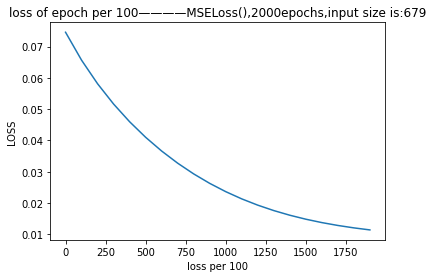

输入步长为679的训练集/验证集上的sMAPE指标：75.92524033622749


In [22]:
'''sgd——mse——679'''
lstm_679_sgd_mse = RNN(679).to(device)
optimizer_adam = torch.optim.Adam(lstm_679_sgd_mse.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_679_sgd_mse.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

'''训练模型，根据训练集的前679个数据得到预测值，然后计算训练集的sMAPE'''
prediction = train(train_input_679, train_output_679, lstm_679_sgd_mse, optimizer_sgd, loss_mse, 679, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 679)

the loss of epoch：   0   is: 0.21972647309303284
the loss of epoch：   100   is: 0.19442474842071533
the loss of epoch：   200   is: 0.17199170589447021
the loss of epoch：   300   is: 0.15212701261043549
the loss of epoch：   400   is: 0.1348615288734436
the loss of epoch：   500   is: 0.12014221400022507
the loss of epoch：   600   is: 0.10756470263004303
the loss of epoch：   700   is: 0.09653005003929138
the loss of epoch：   800   is: 0.08684717118740082
the loss of epoch：   900   is: 0.07888264954090118
the loss of epoch：   1000   is: 0.0725320428609848
the loss of epoch：   1100   is: 0.06779229640960693
the loss of epoch：   1200   is: 0.0646381750702858
the loss of epoch：   1300   is: 0.06266508996486664
the loss of epoch：   1400   is: 0.06163749843835831
the loss of epoch：   1500   is: 0.06108367070555687
the loss of epoch：   1600   is: 0.06078154593706131
the loss of epoch：   1700   is: 0.0606343150138855
the loss of epoch：   1800   is: 0.0605507493019104
the loss of epoch：   1900   i

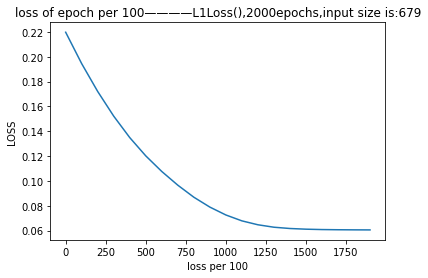

输入步长为679的训练集/验证集上的sMAPE指标：62.74288495493619


In [23]:
'''sgd——mae——679'''
lstm_679_sgd_mae = RNN(679).to(device)
optimizer_adam = torch.optim.Adam(lstm_679_sgd_mae.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_679_sgd_mae.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

prediction = train(train_input_679, train_output_679, lstm_679_sgd_mae, optimizer_sgd, loss_mae, 679, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 679)

the loss of epoch：   0   is: 0.06269953399896622
the loss of epoch：   100   is: 0.0051439255475997925
the loss of epoch：   200   is: 0.00309691671282053
the loss of epoch：   300   is: 0.0028364164754748344
the loss of epoch：   400   is: 0.00275994255207479
the loss of epoch：   500   is: 0.002749581588432193
the loss of epoch：   600   is: 0.002711399458348751
the loss of epoch：   700   is: 0.0027011011261492968
the loss of epoch：   800   is: 0.0026941101532429457
the loss of epoch：   900   is: 0.002688464941456914
the loss of epoch：   1000   is: 0.00268443557433784
the loss of epoch：   1100   is: 0.0026831054128706455
the loss of epoch：   1200   is: 0.0026924978010356426
the loss of epoch：   1300   is: 0.0026759086176753044
the loss of epoch：   1400   is: 0.0026737460866570473
the loss of epoch：   1500   is: 0.0026721563190221786
the loss of epoch：   1600   is: 0.0026701209135353565
the loss of epoch：   1700   is: 0.0026685979682952166
the loss of epoch：   1800   is: 0.00267202174291014

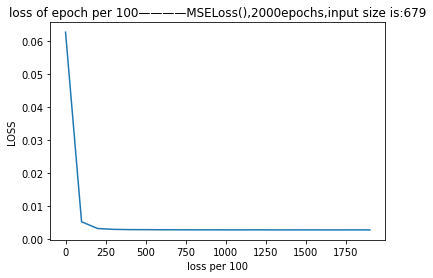

输入步长为679的训练集/验证集上的sMAPE指标：60.40515129697035


In [24]:
'''adam——mse——679'''
lstm_679_adam_mse = RNN(679).to(device)
optimizer_adam = torch.optim.Adam(lstm_679_adam_mse.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_679_adam_mse.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

prediction = train(train_input_679, train_output_679, lstm_679_adam_mse, optimizer_adam, loss_mse, 679, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 679)

the loss of epoch：   0   is: 0.06206181272864342
the loss of epoch：   100   is: 0.05658714845776558
the loss of epoch：   200   is: 0.051773443818092346
the loss of epoch：   300   is: 0.04751182347536087
the loss of epoch：   400   is: 0.04371751844882965
the loss of epoch：   500   is: 0.04032345488667488
the loss of epoch：   600   is: 0.0372757725417614
the loss of epoch：   700   is: 0.034530602395534515
the loss of epoch：   800   is: 0.03205173835158348
the loss of epoch：   900   is: 0.029808908700942993
the loss of epoch：   1000   is: 0.02777649275958538
the loss of epoch：   1100   is: 0.02593257836997509
the loss of epoch：   1200   is: 0.02425823174417019
the loss of epoch：   1300   is: 0.022736920043826103
the loss of epoch：   1400   is: 0.02135412208735943
the loss of epoch：   1500   is: 0.020096946507692337
the loss of epoch：   1600   is: 0.01895391196012497
the loss of epoch：   1700   is: 0.017914704978466034
the loss of epoch：   1800   is: 0.01697004772722721
the loss of epoch： 

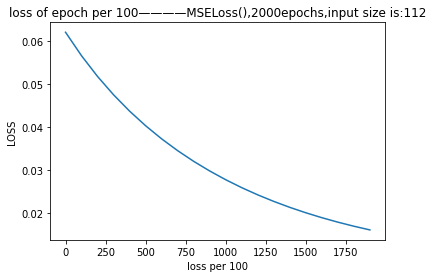

输入步长为112的训练集/验证集上的sMAPE指标：99.95504439419128


In [25]:
'''sgd——mse——112'''
lstm_112_sgd_mse = RNN(112).to(device)
optimizer_adam = torch.optim.Adam(lstm_112_sgd_mse.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_112_sgd_mse.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

prediction = train(train_input_112, train_output_112, lstm_112_sgd_mse, optimizer_sgd, loss_mse, 112, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 112)

the loss of epoch：   0   is: 0.1861419826745987
the loss of epoch：   100   is: 0.1680230349302292
the loss of epoch：   200   is: 0.15135031938552856
the loss of epoch：   300   is: 0.13602964580059052
the loss of epoch：   400   is: 0.12210798263549805
the loss of epoch：   500   is: 0.10981887578964233
the loss of epoch：   600   is: 0.09912072867155075
the loss of epoch：   700   is: 0.09030016511678696
the loss of epoch：   800   is: 0.08325088769197464
the loss of epoch：   900   is: 0.07774869352579117
the loss of epoch：   1000   is: 0.07354728132486343
the loss of epoch：   1100   is: 0.07053586095571518
the loss of epoch：   1200   is: 0.06838255375623703
the loss of epoch：   1300   is: 0.06688708066940308
the loss of epoch：   1400   is: 0.06580784171819687
the loss of epoch：   1500   is: 0.06502169370651245
the loss of epoch：   1600   is: 0.06452124565839767
the loss of epoch：   1700   is: 0.06421306729316711
the loss of epoch：   1800   is: 0.06400857865810394
the loss of epoch：   1900 

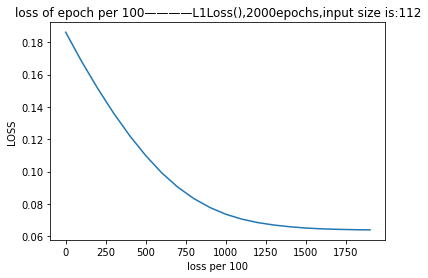

输入步长为112的训练集/验证集上的sMAPE指标：64.7648080051696


In [26]:
'''sgd——mae——112'''
lstm_112_sgd_mae = RNN(112).to(device)
optimizer_adam = torch.optim.Adam(lstm_112_sgd_mae.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_112_sgd_mae.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

prediction = train(train_input_112, train_output_112, lstm_112_sgd_mae, optimizer_sgd, loss_mae, 112, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 112)

the loss of epoch：   0   is: 0.05767542123794556
the loss of epoch：   100   is: 0.007882297970354557
the loss of epoch：   200   is: 0.006597958039492369
the loss of epoch：   300   is: 0.005035987123847008
the loss of epoch：   400   is: 0.004051286727190018
the loss of epoch：   500   is: 0.003390165977180004
the loss of epoch：   600   is: 0.0033117637503892183
the loss of epoch：   700   is: 0.003211599076166749
the loss of epoch：   800   is: 0.0031815730035305023
the loss of epoch：   900   is: 0.003180714789777994
the loss of epoch：   1000   is: 0.0031835010740906
the loss of epoch：   1100   is: 0.0031854240223765373
the loss of epoch：   1200   is: 0.003185846609994769
the loss of epoch：   1300   is: 0.003185091307386756
the loss of epoch：   1400   is: 0.0031835122499614954
the loss of epoch：   1500   is: 0.0031814828980714083
the loss of epoch：   1600   is: 0.0031799289863556623
the loss of epoch：   1700   is: 0.003175948513671756
the loss of epoch：   1800   is: 0.00317786680534482
the

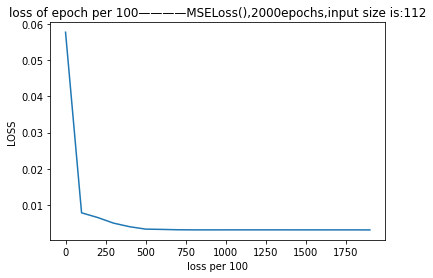

输入步长为112的训练集/验证集上的sMAPE指标：61.32147504022524


In [28]:
'''adam——mse——112'''
lstm_112_adam_mse = RNN(112).to(device)
optimizer_adam = torch.optim.Adam(lstm_112_adam_mse.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_112_adam_mse.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

prediction = train(train_input_112, train_output_112, lstm_112_adam_mse, optimizer_adam, loss_mse, 112, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 112)

the loss of epoch：   0   is: 0.05976476892828941
the loss of epoch：   100   is: 0.054655931890010834
the loss of epoch：   200   is: 0.0501018725335598
the loss of epoch：   300   is: 0.046022929251194
the loss of epoch：   400   is: 0.042355455458164215
the loss of epoch：   500   is: 0.039047833532094955
the loss of epoch：   600   is: 0.03605763614177704
the loss of epoch：   700   is: 0.033349499106407166
the loss of epoch：   800   is: 0.030893588438630104
the loss of epoch：   900   is: 0.028664397075772285
the loss of epoch：   1000   is: 0.026639889925718307
the loss of epoch：   1100   is: 0.02480081096291542
the loss of epoch：   1200   is: 0.023130176588892937
the loss of epoch：   1300   is: 0.021612871438264847
the loss of epoch：   1400   is: 0.0202353335916996
the loss of epoch：   1500   is: 0.018985318019986153
the loss of epoch：   1600   is: 0.017851708456873894
the loss of epoch：   1700   is: 0.016824377700686455
the loss of epoch：   1800   is: 0.015894049778580666
the loss of epo

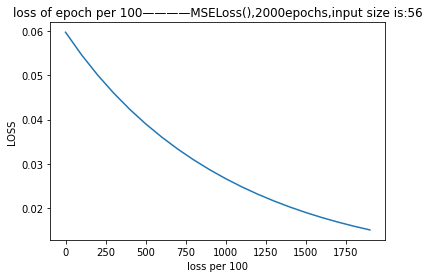

输入步长为56的训练集/验证集上的sMAPE指标：95.98402748028373


In [27]:
'''sgd——mse——56'''
lstm_56_sgd_mse = RNN(56).to(device)
optimizer_adam = torch.optim.Adam(lstm_56_sgd_mse.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_56_sgd_mse.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

'''训练模型，根据训练集的前679个数据得到预测值，然后计算训练集的sMAPE'''
prediction = train(train_input_56, train_output_56, lstm_56_sgd_mse, optimizer_sgd, loss_mse, 56, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 56)

the loss of epoch：   0   is: 0.1871212124824524
the loss of epoch：   100   is: 0.17052040994167328
the loss of epoch：   200   is: 0.15503491461277008
the loss of epoch：   300   is: 0.14050519466400146
the loss of epoch：   400   is: 0.12698350846767426
the loss of epoch：   500   is: 0.11465923488140106
the loss of epoch：   600   is: 0.10365138947963715
the loss of epoch：   700   is: 0.09406547248363495
the loss of epoch：   800   is: 0.08598829805850983
the loss of epoch：   900   is: 0.0793766900897026
the loss of epoch：   1000   is: 0.07422240078449249
the loss of epoch：   1100   is: 0.07034957408905029
the loss of epoch：   1200   is: 0.0675702840089798
the loss of epoch：   1300   is: 0.06562960892915726
the loss of epoch：   1400   is: 0.06431175023317337
the loss of epoch：   1500   is: 0.06344465166330338
the loss of epoch：   1600   is: 0.06289037317037582
the loss of epoch：   1700   is: 0.0625319853425026
the loss of epoch：   1800   is: 0.06230970844626427
the loss of epoch：   1900   

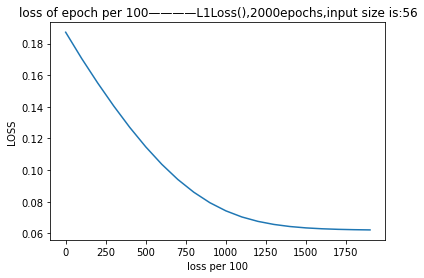

输入步长为56的训练集/验证集上的sMAPE指标：64.55246960696516


In [29]:
'''sgd——mae——56'''
lstm_56_sgd_mae = RNN(56).to(device)
optimizer_adam = torch.optim.Adam(lstm_56_sgd_mae.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_56_sgd_mae.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

'''训练模型，根据训练集的前679个数据得到预测值，然后计算训练集的sMAPE'''
prediction = train(train_input_56, train_output_56, lstm_56_sgd_mae, optimizer_sgd, loss_mae, 56, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 56)

the loss of epoch：   0   is: 0.051267269998788834
the loss of epoch：   100   is: 0.007571266498416662
the loss of epoch：   200   is: 0.006863871589303017
the loss of epoch：   300   is: 0.0052582500502467155
the loss of epoch：   400   is: 0.004388169385492802
the loss of epoch：   500   is: 0.004268696065992117
the loss of epoch：   600   is: 0.004229058977216482
the loss of epoch：   700   is: 0.004210238344967365
the loss of epoch：   800   is: 0.004199610557407141
the loss of epoch：   900   is: 0.004193840082734823
the loss of epoch：   1000   is: 0.004191053565591574
the loss of epoch：   1100   is: 0.00418891804292798
the loss of epoch：   1200   is: 0.004186117555946112
the loss of epoch：   1300   is: 0.0041826036758720875
the loss of epoch：   1400   is: 0.004178592469543219
the loss of epoch：   1500   is: 0.004174534697085619
the loss of epoch：   1600   is: 0.0041705528274178505
the loss of epoch：   1700   is: 0.0041672769002616405
the loss of epoch：   1800   is: 0.004163460806012154
th

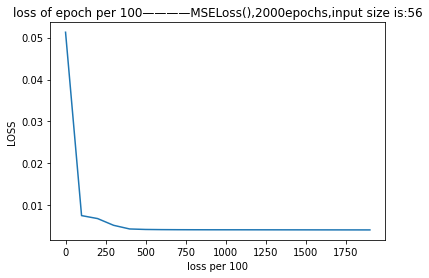

输入步长为56的训练集/验证集上的sMAPE指标：58.16198057800281


In [30]:
'''adam——mse——56'''
lstm_56_adam_mse = RNN(56).to(device)
optimizer_adam = torch.optim.Adam(lstm_56_adam_mse.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_56_adam_mse.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

'''训练模型，根据训练集的前679个数据得到预测值，然后计算训练集的sMAPE'''
prediction = train(train_input_56, train_output_56, lstm_56_adam_mse, optimizer_adam, loss_mse, 56, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, 56)

以下是对验证集的sMAPE指标计算

In [31]:
'''sgd——mse——56'''
input = dev_input_56[:, [dev_input_56.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_56_sgd_mse(input).to('cpu') #计算精度数据回到cpu上
acc = cal_sMAPE_train(dev_data_rows, prediction, 56)

输入步长为56的训练集/验证集上的sMAPE指标：92.69592452847762


In [32]:
'''sgd——mae——56'''
input = dev_input_56[:, [dev_input_56.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_56_sgd_mae(input).to('cpu')
acc = cal_sMAPE_train(dev_data_rows, prediction, 56)

输入步长为56的训练集/验证集上的sMAPE指标：59.53005247638973


In [33]:
'''adam——mse——56'''
input = dev_input_56[:, [dev_input_56.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_56_adam_mse(input).to('cpu')
acc = cal_sMAPE_train(dev_data_rows, prediction, 56)

输入步长为56的训练集/验证集上的sMAPE指标：47.601929996697805


In [34]:
'''sgd——mse——112'''
input = dev_input_112[:, [dev_input_112.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_112_sgd_mse(input).to('cpu') #计算精度数据回到cpu上
acc = cal_sMAPE_train(dev_data_rows, prediction, 112)

输入步长为112的训练集/验证集上的sMAPE指标：96.72883156242048


In [35]:
'''sgd——mae——112'''
input = dev_input_112[:, [dev_input_112.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_112_sgd_mae(input).to('cpu') #计算精度数据回到cpu上
acc = cal_sMAPE_train(dev_data_rows, prediction, 112)

输入步长为112的训练集/验证集上的sMAPE指标：59.92738108623055


In [36]:
'''adam——mse——112'''
input = dev_input_112[:, [dev_input_112.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_112_adam_mse(input).to('cpu') #计算精度数据回到cpu上
acc = cal_sMAPE_train(dev_data_rows, prediction, 112)

输入步长为112的训练集/验证集上的sMAPE指标：50.834736206032446


In [37]:
'''sgd——mse——679'''
input = dev_input_679[:, [dev_input_679.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_679_sgd_mse(input).to('cpu') #计算精度数据回到cpu上
acc = cal_sMAPE_train(dev_data_rows, prediction, 679)

输入步长为679的训练集/验证集上的sMAPE指标：73.37111356661732


In [38]:
'''sgd——mae——679'''
input = dev_input_679[:, [dev_input_679.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_679_sgd_mae(input).to('cpu') #计算精度数据回到cpu上
acc = cal_sMAPE_train(dev_data_rows, prediction, 679)

输入步长为679的训练集/验证集上的sMAPE指标：57.917027599483475


In [39]:
'''sgd——mse——679'''
input = dev_input_679[:, [dev_input_679.shape[1]-1], :].to(torch.float32).to(device)#取验证集输入数据的最后一个批次进行预测
prediction = lstm_679_adam_mse(input).to('cpu') #计算精度数据回到cpu上
acc = cal_sMAPE_train(dev_data_rows, prediction, 679)

输入步长为679的训练集/验证集上的sMAPE指标：52.447627590913456
